<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span><ul class="toc-item"><li><span><a href="#--[x]--Jupyter-Notebook-открыт" data-toc-modified-id="--[x]--Jupyter-Notebook-открыт-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>- [x]  Jupyter Notebook открыт</a></span></li></ul></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib as plt


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from pymystem3 import Mystem
from sklearn.model_selection import cross_val_score


from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from random import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

import nltk
import re 
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nikita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nikita/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [5]:
df.toxic.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

<AxesSubplot:>

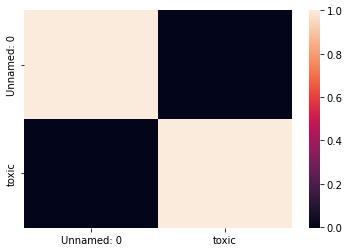

In [6]:
sns.heatmap(df.corr())

Принял решение удалить столбец Unnamed: 0, так как он не информативен.

In [7]:
df = df.drop('Unnamed: 0',axis=1)

In [8]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    clean = " ".join(re.sub(r'[^a-zA-z]', ' ', text).lower().split())
    word_list = nltk.word_tokenize(clean)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])    
    return lemmatized_output

df['lemmatize'] = df['text'].apply(clean_text)

In [9]:
df 

,text,toxic,lemmatize
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159288,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ho...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159290,And it looks like it was actually you who put ...,0,and it look like it wa actually you who put on...


In [10]:
features = df['lemmatize']
target = df['toxic']

In [11]:
features_train,features_test,target_train,target_test = train_test_split(features,target,
                                                                         test_size=0.2,
                                                                         random_state =12345,
                                                                         shuffle=True
                                                                         )

In [12]:
print(features_train.shape)


(127433,)


In [13]:
print(target_train.shape)


(127433,)


In [14]:
print(features_test.shape)
print(target_test.shape)

(31859,)
(31859,)


In [16]:
count_tf_idf = TfidfVectorizer(stop_words= 'english')

#nltk.download('stopwords')
#stopwords = set(nltk_stopwords.words('english'))


tf_idf_train = count_tf_idf.fit_transform(features_train)
tf_idf_test = count_tf_idf.transform(features_test)


In [17]:
print(tf_idf_train.shape)
print(tf_idf_test.shape)


(127433, 141527)
(31859, 141527)


## Обучение

#### LogisticRegression

In [18]:
clf_lr = LogisticRegression(random_state=12345, solver='sag',class_weight='balanced')
parametrs_lr = { 'C': range (1, 10),
              'max_iter': [100],
              }
grid_lr = GridSearchCV(clf_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(tf_idf_train, target_train)
grid_lr.best_params_


/Users/nikita/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nikita/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nikita/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nikita/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nikita/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nikita/opt/anaconda3/lib/python3.9/sit

{'C': 5, 'max_iter': 100}

In [19]:
grid_lr.best_score_

0.7568840186487843

In [22]:
cat = CatBoostClassifier()

parametrs = {'iterations': [200],
        'depth': [5]}

grid_search_result = GridSearchCV(cat,parametrs)

In [23]:
grid_search_result.fit(tf_idf_train, target_train)
grid_search_result.best_params_
grid_search_result.best_score_

Learning rate set to 0.324686
0:	learn: 0.4219964	total: 462ms	remaining: 1m 31s
1:	learn: 0.3176756	total: 777ms	remaining: 1m 16s
2:	learn: 0.2735139	total: 1.01s	remaining: 1m 6s
3:	learn: 0.2508997	total: 1.24s	remaining: 1m
4:	learn: 0.2371453	total: 1.48s	remaining: 57.8s
5:	learn: 0.2269856	total: 1.71s	remaining: 55.4s
6:	learn: 0.2211919	total: 1.93s	remaining: 53.3s
7:	learn: 0.2166954	total: 2.16s	remaining: 52s
8:	learn: 0.2129238	total: 2.39s	remaining: 50.7s
9:	learn: 0.2093971	total: 2.61s	remaining: 49.6s
10:	learn: 0.2068390	total: 2.84s	remaining: 48.8s
11:	learn: 0.2044237	total: 3.09s	remaining: 48.4s
12:	learn: 0.2005777	total: 3.37s	remaining: 48.5s
13:	learn: 0.1983318	total: 3.63s	remaining: 48.2s
14:	learn: 0.1961533	total: 3.91s	remaining: 48.2s
15:	learn: 0.1939173	total: 4.16s	remaining: 47.8s
16:	learn: 0.1923152	total: 4.4s	remaining: 47.4s
17:	learn: 0.1900121	total: 4.65s	remaining: 47s
18:	learn: 0.1879911	total: 4.89s	remaining: 46.6s
19:	learn: 0.1865

0.9540778342894924

#### LightGBM

In [25]:
model = LGBMClassifier()
parameters = {'max_iter': [100],
              'max_depth': range (15,20)} 

greed3 = GridSearchCV(model, param_grid=parameters)
greed3.fit(tf_idf_train, target_train)
greed3.best_score_

0.9533166446847152

In [34]:
predicted_lr= grid_lr.predict(tf_idf_test)
f1_log_r_1 = f1_score(target_test, predicted_lr)
f1_log_r_1

0.7651215375918597

## Выводы

Был удален не информативный столбец,данные были разбиты на трейн и тест,проведена леммитизация и очистка текста, для лучшей понимания модели.Рассматривыались метрики  - LightGBM,CatBoostClassifier,LogisticRegression
Лучшей моделью оказалась LogisticRegression

## Чек-лист проверки

### - [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны